# Fruit Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) to classify fruits into 5 categories:
- Banana
- Cherry
- Grape
- Mango
- Peach

The model is trained on the provided dataset and evaluated on test images.

In [1]:
# Install required packages
!pip install tensorflow opencv-python matplotlib seaborn tabulate

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from google.colab import files
import shutil
from PIL import Image
import io
import time
import pandas as pd
from tabulate import tabulate
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Dataset Setup
In this section, we'll upload and extract the dataset, then examine its structure.

In [2]:
def setup_dataset():
    print("Setting up the dataset")

    # Check if the dataset is already extracted
    if not os.path.exists("Fruit Classification"):
        print("Please upload the dataset zip file...")

        # Upload the dataset ZIP file
        uploaded = files.upload()

        # Get the first uploaded file name
        zip_file_name = list(uploaded.keys())[0]

        # Extract the uploaded ZIP file
        print(f"Extracting {zip_file_name}...")
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall(".")

        print("Extraction completed.")
    else:
        print("Dataset folder already exists, skipping extraction.")

    # Let's check what files and directories we actually have
    print("Current directory contents:")
    all_files = os.listdir(".")
    for item in all_files:
        print(f"  - {item}")

    # Try to find the correct paths
    possible_base_dirs = [
        "Fruit Classification-20250503T141440Z-001/Fruit Classification",
        "Fruit Classification",
        "Fruit"
    ]

    base_dir = None
    for dir_path in possible_base_dirs:
        if os.path.exists(dir_path):
            print(f"Found directory: {dir_path}")
            if os.path.exists(os.path.join(dir_path, "Train")):
                base_dir = dir_path
                print(f"Using base directory: {base_dir}")
                break

    if base_dir is None:
        raise FileNotFoundError("Could not find the dataset directory with Train folder")

    train_dir = os.path.join(base_dir, "Train")
    test_dir = os.path.join(base_dir, "Test")

    # Create cleaned data directory
    clean_dir = os.path.join(base_dir, "Clean_Train")
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
        print("Created clean data directory for validated images")

    # Display directory structure
    print("\nAvailable training classes:")
    for item in os.listdir(train_dir):
        item_path = os.path.join(train_dir, item)
        if os.path.isdir(item_path):
            num_images = len(os.listdir(item_path))
            print(f"  - {item}: {num_images} images")

    print("\nTest directory contents:")
    test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
    print(f"  - {len(test_images)} test images")

    # More robust validation function to filter corrupted images
    def validate_image(file_path):
        try:
            # Try multiple methods to validate the image
            # Method 1: OpenCV
            img = cv2.imread(file_path)
            if img is None:
                return False

            # Method 2: PIL
            try:
                with open(file_path, 'rb') as f:
                    img_bytes = f.read()
                    pil_img = Image.open(io.BytesIO(img_bytes))
                    pil_img.verify()  # Verify the image is valid
            except:
                return False

            # Both methods passed
            return True
        except:
            return False

    # Process and copy valid images to clean directory
    print("\nValidating images to remove corrupted files...")
    corrupted_count = 0
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            # Create class directory in clean_dir if it doesn't exist
            clean_class_dir = os.path.join(clean_dir, class_name)
            if not os.path.exists(clean_class_dir):
                os.makedirs(clean_class_dir)

            valid_count = 0
            total_count = 0
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                total_count += 1
                if validate_image(img_path):
                    valid_count += 1
                    # Copy valid image to clean directory
                    shutil.copy2(img_path, os.path.join(clean_class_dir, img_file))
                else:
                    corrupted_count += 1
            print(f"  - {class_name}: {valid_count}/{total_count} valid images")

    print(f"\nTotal corrupted images found: {corrupted_count}")
    print(f"Clean dataset created at: {clean_dir}")

    return base_dir, clean_dir, test_dir

# Run the setup function
base_dir, clean_train_dir, test_dir = setup_dataset()

Setting up the dataset
Please upload the dataset zip file...


Saving Fruit Classification-20250503T141440Z-001.zip to Fruit Classification-20250503T141440Z-001.zip
Extracting Fruit Classification-20250503T141440Z-001.zip...
Extraction completed.
Current directory contents:
  - .config
  - Fruit Classification
  - Fruit Classification-20250503T141440Z-001.zip
  - sample_data
Found directory: Fruit Classification
Using base directory: Fruit Classification
Created clean data directory for validated images

Available training classes:
  - Cherry: 1229 images
  - Mango: 915 images
  - Banana: 1429 images
  - Grape: 1475 images
  - Peach: 1229 images

Test directory contents:
  - 5 test images

Validating images to remove corrupted files...
  - Cherry: 1222/1229 valid images
  - Mango: 908/915 valid images
  - Banana: 1422/1429 valid images
  - Grape: 1468/1475 valid images
  - Peach: 1222/1229 valid images

Total corrupted images found: 35
Clean dataset created at: Fruit Classification/Clean_Train


## Class Distribution
Let's visualize the distribution of images across different fruit classes after cleaning the dataset.

Visualizing class distribution after cleaning


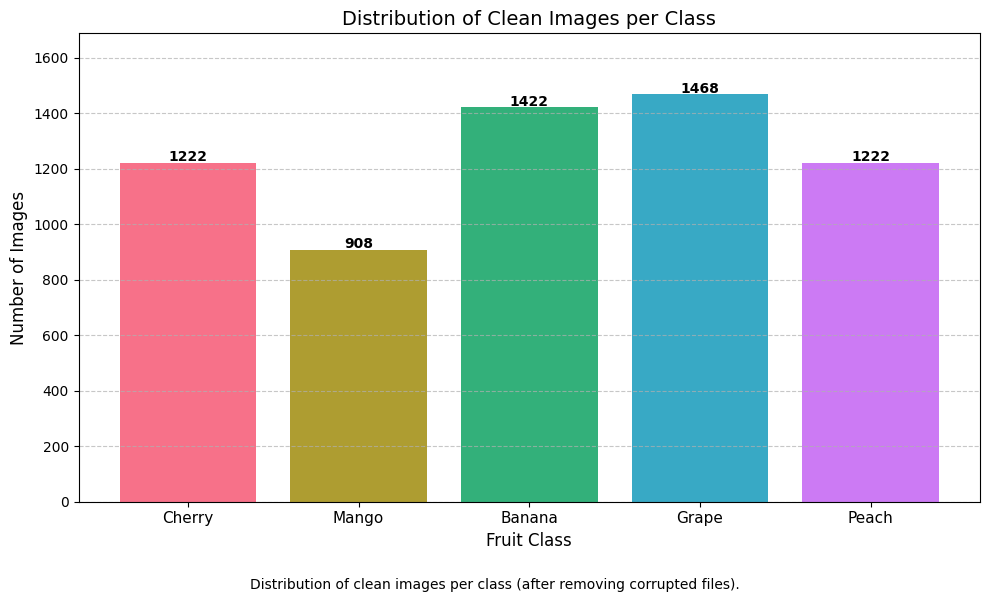

Total number of clean images: 6242


In [4]:
def plot_class_distribution(clean_dir):
    print("Visualizing class distribution after cleaning")

    try:
        # Get counts of images per class
        class_counts = {}
        for class_name in os.listdir(clean_dir):
            class_path = os.path.join(clean_dir, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                class_counts[class_name] = num_images

        if not class_counts:
            print("No classes found in clean directory")
            return

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        classes = list(class_counts.keys())
        counts = [class_counts[cls] for cls in classes]

        # Use a colorful palette
        colors = sns.color_palette("husl", len(classes))

        # Create the bar chart
        bars = plt.bar(classes, counts, color=colors)

        # Add count labels on top of each bar
        for bar, count in zip(bars, counts):
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 5,
                str(count),
                ha='center',
                fontweight='bold'
            )

        # Add labels and title
        plt.xlabel('Fruit Class', fontsize=12)
        plt.ylabel('Number of Images', fontsize=12)
        plt.title('Distribution of Clean Images per Class', fontsize=14)
        plt.xticks(rotation=0, fontsize=11)
        plt.ylim(0, max(counts) * 1.15)  # Add 15% space above the highest bar

        # Add grid lines for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add a caption below the chart
        plt.figtext(0.5, 0.01,
                   "Distribution of clean images per class (after removing corrupted files).",
                   ha='center',
                   fontsize=10)

        plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for caption
        plt.show()

        # Print the total count
        total_images = sum(counts)
        print(f"Total number of clean images: {total_images}")

    except Exception as e:
        print(f"Error plotting class distribution: {str(e)}")
        print("Skipping class distribution visualization.")

# Plot the class distribution
plot_class_distribution(clean_train_dir)

## Data Preprocessing and Augmentation
In this section, we'll set up data augmentation and preprocessing to prepare our images for training.

In [ ]:
def setup_data_generators(train_dir, img_height=224, img_width=224, batch_size=32):
    print("Setting up data augmentation and preprocessing")

    try:
        # Custom preprocessing function to ensure image validity
        def safe_preprocessing(img):
            try:
                # Handle different input types
                if isinstance(img, str):  # If it's a file path
                    try:
                        img = cv2.imread(img)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    except:
                        return np.zeros((img_height, img_width, 3))

                # Check if image is valid
                if img is None or (isinstance(img, np.ndarray) and (img.size == 0 or np.isnan(img).any())):
                    return np.zeros((img_height, img_width, 3))

                # Ensure it has correct dimensions
                if len(img.shape) != 3 or img.shape[2] != 3:
                    return np.zeros((img_height, img_width, 3))

                return img
            except:
                # Return blank image on any error
                return np.zeros((img_height, img_width, 3))

        # Create a data generator with validation split
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2,  # Use 20% of the data for validation
            preprocessing_function=safe_preprocessing
        )

        test_datagen = ImageDataGenerator(
            rescale=1./255,
            preprocessing_function=safe_preprocessing
        )

        # Consider using a smaller batch size to reduce impact of corrupted files
        if batch_size > 16:
            print(f"Using batch size {batch_size}. If you encounter memory issues, try reducing it.")

        # Add exception handling directly to flow_from_directory calls
        print("Creating train and validation generators")
        try:
            train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode='categorical',
                subset='training'
            )

            validation_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode='categorical',
                subset='validation'
            )

            # Get class indices for mapping later
            class_indices = train_generator.class_indices
            class_names = list(class_indices.keys())
            print(f"Class names: {class_names}")

            return train_generator, validation_generator, class_indices, class_names
        except Exception as e:
            print(f"Error in generator creation: {str(e)}")
            raise e

    except Exception as e:
        print(f"\nError setting up data generators with full augmentation: {str(e)}")
        print("Trying with minimal augmentation...")

        try:
            # Fallback to minimal augmentation
            simple_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.2  # Use 20% of the data for validation
            )

            # Reduce batch size for the fallback approach
            fallback_batch_size = min(16, batch_size)
            print(f"Using reduced batch size: {fallback_batch_size}")

            train_generator = simple_datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=fallback_batch_size,
                class_mode='categorical',
                subset='training'
            )

            validation_generator = simple_datagen.flow_from_directory(
                train_dir,
                target_size=(img_height, img_width),
                batch_size=fallback_batch_size,
                class_mode='categorical',
                subset='validation'
            )

            class_indices = train_generator.class_indices
            class_names = list(class_indices.keys())
            print(f"Class names (fallback): {class_names}")

            return train_generator, validation_generator, class_indices, class_names

        except Exception as e:
            print(f"\nFatal error in data generator setup: {str(e)}")
            raise Exception("Could not set up data generators. Please check your dataset structure.")

# Create a custom data generator for robust training
class RobustDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, original_generator, img_height=224, img_width=224):
        self.original_generator = original_generator
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = original_generator.batch_size
        self.class_indices = original_generator.class_indices
        self.classes = original_generator.classes
        self.n = len(original_generator)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        try:
            # Try to get the batch at index idx
            batch_x, batch_y = self.original_generator[idx]
            return batch_x, batch_y
        except Exception as e:
            print(f"Skipping problematic batch at index {idx}: {str(e)}")
            # Create a dummy batch with zeros
            dummy_x = np.zeros((self.batch_size, self.img_height, self.img_width, 3))
            dummy_y = np.zeros((self.batch_size, len(self.class_indices)))
            return dummy_x, dummy_y

# Define parameters
img_height, img_width = 224, 224
batch_size = 32

# Setup data generators using the clean data directory
train_generator, validation_generator, class_indices, class_names = setup_data_generators(
    clean_train_dir, img_height, img_width, batch_size
)

Setting up data augmentation and preprocessing
Using batch size 32. If you encounter memory issues, try reducing it.
Creating train and validation generators
Found 4996 images belonging to 5 classes.
Found 1246 images belonging to 5 classes.
Class names: ['Banana', 'Cherry', 'Grape', 'Mango', 'Peach']


## Visualize Data Augmentation
Let's see how our augmentation pipeline transforms the images to create variety in our training data.

Visualizing data augmentation effects


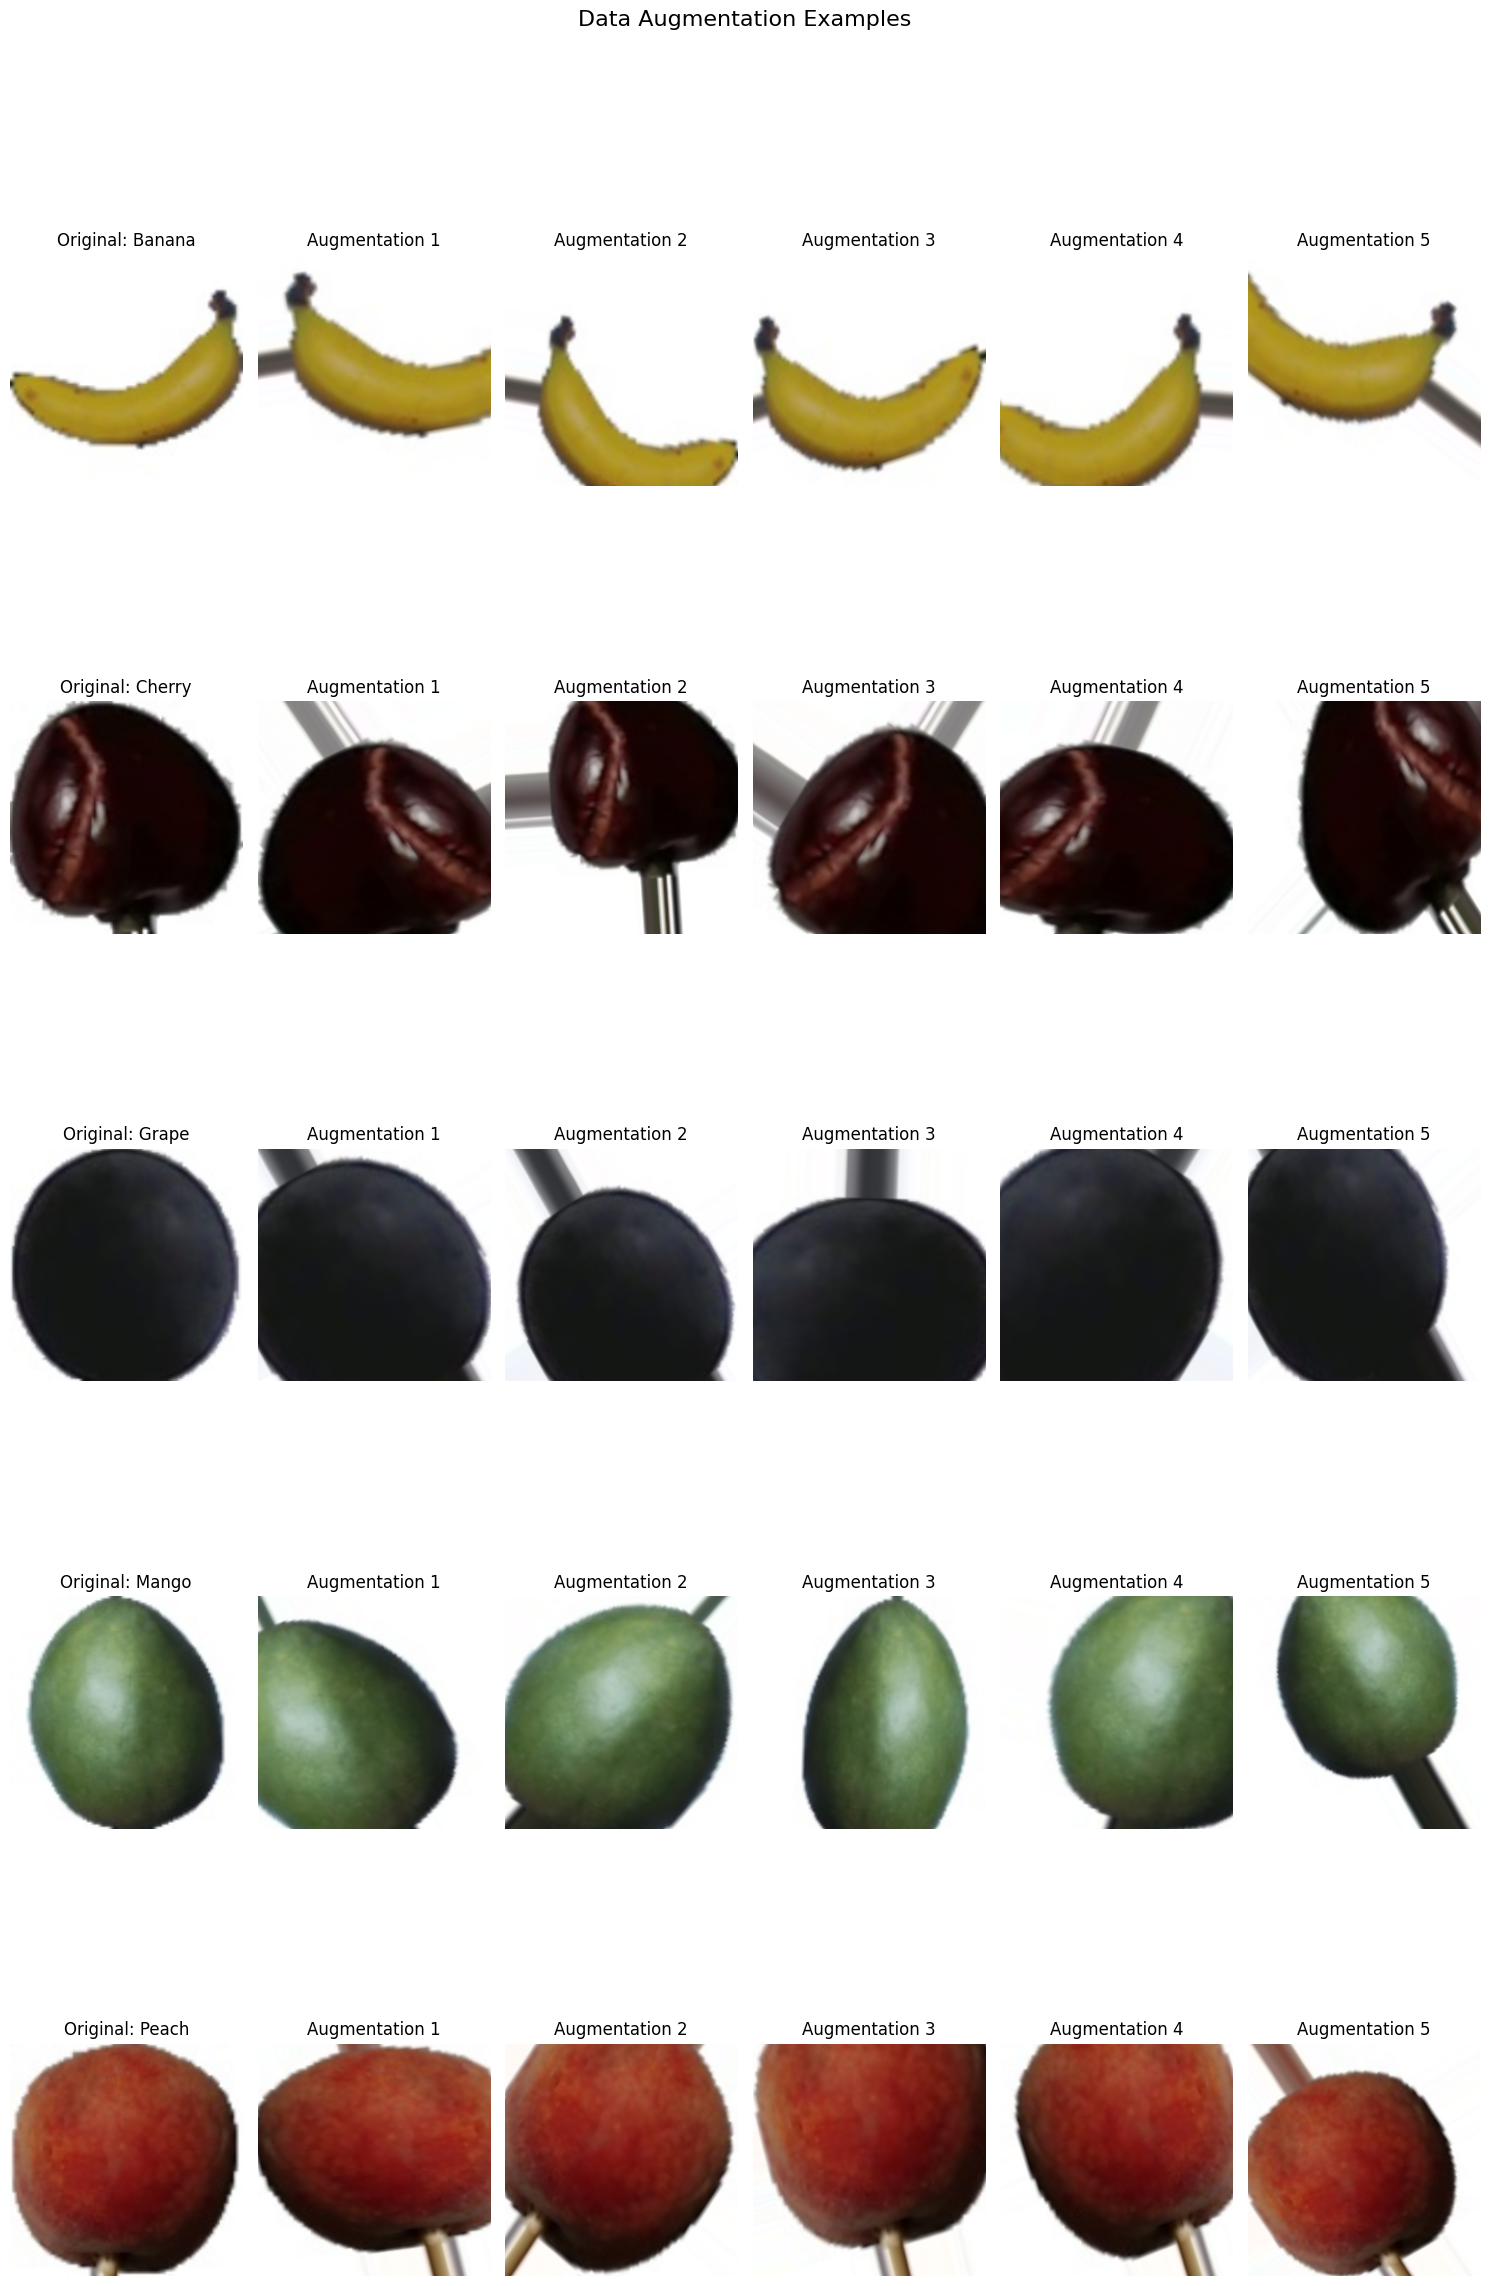

Displayed original and augmented versions of sample images from each class
Augmentations include: rotation, shifting, shearing, zooming, and flipping


In [ ]:
def visualize_augmentation(train_dir, class_names, img_height=224, img_width=224):
    print("Visualizing data augmentation effects")

    # Create a directory to save one sample image per class
    sample_images_dir = "sample_images"
    if not os.path.exists(sample_images_dir):
        os.makedirs(sample_images_dir)

    # Get one sample image per class
    sample_images = []
    sample_image_paths = []

    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        if os.path.exists(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                # Get the first valid image
                for img_file in image_files:
                    img_path = os.path.join(class_dir, img_file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (img_height, img_width))
                            sample_images.append(img)
                            sample_image_paths.append(img_path)
                            # Save the sample image for augmentation
                            sample_img_path = os.path.join(sample_images_dir, f"{class_name}_sample.jpg")
                            cv2.imwrite(sample_img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                            break
                    except:
                        continue

    if not sample_images:
        print("Could not find any valid sample images for augmentation visualization")
        return

    # Create data augmentation object with various transformations
    augmentation = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Plot original and augmented images
    plt.figure(figsize=(15, 5 * len(sample_images)))

    for i, (img, img_path) in enumerate(zip(sample_images, sample_image_paths)):
        class_name = os.path.basename(os.path.dirname(img_path))

        # Explicitly convert to float32 and normalize to [0,1] range for augmentation
        img_float = img.astype(np.float32) / 255.0

        # Reshape for the augmentation generator (needs batch dimension)
        img_batch = np.expand_dims(img_float, 0)

        # Get augmented images - they will be in [0,1] range
        aug_iter = augmentation.flow(img_batch, batch_size=1)
        aug_images = [next(aug_iter)[0] for _ in range(5)]  # Get 5 different augmentations

        # Plot original image
        plt.subplot(len(sample_images), 6, i*6 + 1)
        plt.imshow(img_float)  # Original image normalized to [0,1]
        plt.title(f"Original: {class_name}")
        plt.axis('off')

        # Plot augmented versions
        for j, aug_img in enumerate(aug_images):
            plt.subplot(len(sample_images), 6, i*6 + j + 2)
            plt.imshow(aug_img)  # Augmented image already in [0,1] range
            plt.title(f"Augmentation {j+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Data Augmentation Examples", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

    print("Displayed original and augmented versions of sample images from each class")
    print("Augmentations include: rotation, shifting, shearing, zooming, and flipping")

# Visualize data augmentation
visualize_augmentation(clean_train_dir, class_names, img_height, img_width)

Visualizing sample images


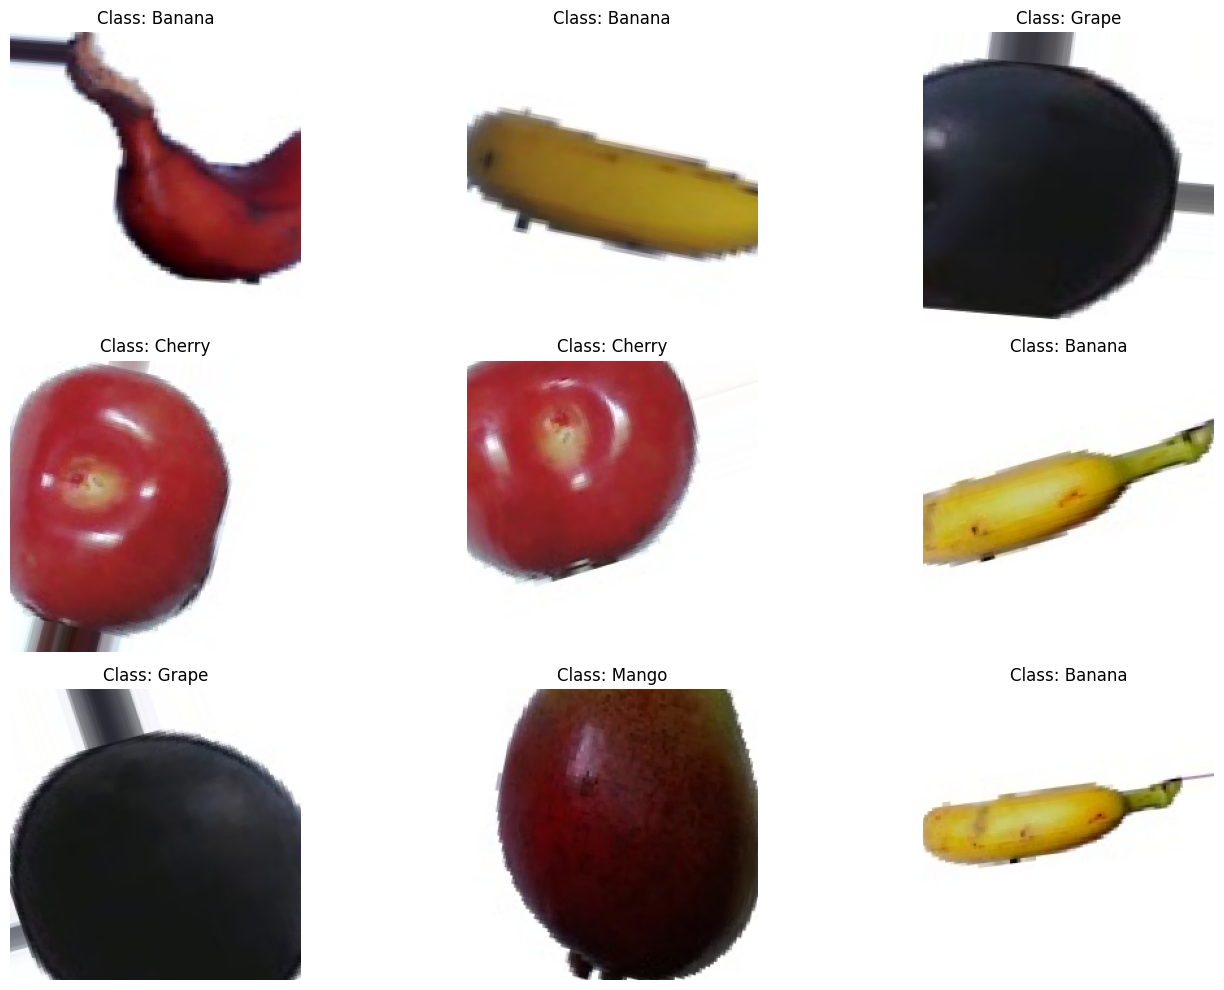

In [ ]:
def visualize_samples(generator, class_indices):
    print("Visualizing sample images")

    plt.figure(figsize=(15, 10))
    successful_plots = 0
    max_attempts = 30  # Increased number of attempts to find valid images

    try:
        # Ensure generator is fresh
        if hasattr(generator, 'reset'):
            generator.reset()

        for attempt in range(max_attempts):
            if successful_plots >= 9:  # We want 9 images
                break

            try:
                # Get a batch of images
                if isinstance(generator, RobustDataGenerator):
                    images, labels = next(generator)
                else:
                    images, labels = next(generator)

                # Skip empty batches
                if len(images) == 0:
                    continue

                # Iterate through batch to find valid images
                for i in range(min(len(images), 5)):  # Check up to 5 images in this batch
                    # Make sure the image is valid (not all zeros or NaN)
                    img = images[i]
                    if np.isnan(img).any() or img.max() == 0:
                        continue

                    # Display the image
                    plt.subplot(3, 3, successful_plots+1)
                    plt.imshow(img)

                    # Get the class name from the one-hot encoded label
                    true_class_index = np.argmax(labels[i])
                    true_class = list(class_indices.keys())[true_class_index]

                    plt.title(f"Class: {true_class}")
                    plt.axis('off')

                    successful_plots += 1
                    if successful_plots >= 9:
                        break

            except Exception as e:
                print(f"Warning: Error visualizing sample (attempt {attempt+1}): {str(e)}")
                continue

        if successful_plots == 0:
            print("Could not visualize any samples. All attempts failed.")
        else:
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error in visualization function: {str(e)}")
        print("Skipping visualization step...")

# Visualize sample images
visualize_samples(train_generator, class_indices)

## CNN Model Building
Now we'll build our CNN architecture for fruit classification. We'll implement:
1. A baseline CNN model
2. A deeper model with regularization

In [ ]:
def build_model(img_height=224, img_width=224, num_classes=5):
    print("Building the Baseline CNN model")

    try:
        # Build the baseline model
        model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
            MaxPooling2D(pool_size=(2, 2)),

            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),

            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),

            # Flatten layer
            Flatten(),

            # Fully connected layers (FCN)
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),

            # Output layer
            Dense(num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        print("\nBaseline Model Summary:")
        model.summary()

        return model

    except Exception as e:
        print(f"\nError building baseline model: {str(e)}")
        raise Exception("Could not build baseline model. Please check your TensorFlow installation and available memory.")

# Build baseline model
baseline_model = build_model(img_height, img_width, len(class_names))

Building the Baseline CNN model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Baseline Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,638,853 (196.99 MB)

 Trainable params: 51,638,853 (196.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_deeper_model(img_height=224, img_width=224, num_classes=5):
    print("Building the Deeper CNN model with Regularization")

    try:
        # Build a deeper model with reduced regularization
        deeper_model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.1),  # Reduced dropout rate

            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.1),  # Reduced dropout rate

            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.2),  # Reduced dropout rate

            # Flatten layer
            Flatten(),

            # Fully connected layers (FCN)
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),  # Reduced dropout rate

            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),  # Reduced dropout rate

            # Output layer
            Dense(num_classes, activation='softmax')
        ])

        # Compile model
        deeper_model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        print("\nDeeper Model Summary:")
        deeper_model.summary()

        return deeper_model

    except Exception as e:
        print(f"\nError building deeper model: {str(e)}")
        print("Trying with a more memory-efficient deeper model...")

        # Alternative implementation omitted for brevity
        # You can add fallback implementation if needed

# Build deeper model
deeper_model = build_deeper_model(img_height, img_width, len(class_names))

Building the Deeper CNN model with Regularization

Deeper Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,805,221 (197.62 MB)

 Trainable params: 51,802,789 (197.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
def train_model(model, train_generator, validation_generator, class_names, img_height=224, img_width=224, optimizer_type='adam'):
    print(f"Training the model with {optimizer_type} optimizer")

    # Set optimizer based on the type
    if optimizer_type.lower() == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        print("Using SGD optimizer with learning rate=0.01, momentum=0.9")
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    else:  # default to Adam
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        print("Using Adam optimizer with learning rate=0.0001")
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    # Create a custom callback to handle errors during training
    class ErrorHandlingCallback(tf.keras.callbacks.Callback):
        def on_batch_end(self, batch, logs=None):
            if logs and np.isnan(logs.get('loss', 0)):
                print("\nNaN loss detected, terminating training...")
                self.model.stop_training = True

    # Define callbacks with the new error handler
    callbacks = [
        ModelCheckpoint(f'fruit_model_{optimizer_type}_best.h5', save_best_only=True, monitor='val_accuracy'),
        EarlyStopping(patience=10, restore_best_weights=True),
        ErrorHandlingCallback()
    ]

    # Create robust generators (wrapping the original generators)
    robust_train_gen = RobustDataGenerator(train_generator, img_height, img_width)
    robust_val_gen = RobustDataGenerator(validation_generator, img_height, img_width)

    # Record start time for computational efficiency analysis
    start_time = time.time()

    # Training with error handling
    try:
        print("Using robust training approach with error handling...")
        history = model.fit(
            robust_train_gen,
            steps_per_epoch=len(train_generator),
            epochs=50,
            validation_data=robust_val_gen,
            validation_steps=len(validation_generator),
            callbacks=callbacks,
            verbose=1
        )

        # Calculate training time
        training_time = time.time() - start_time
        print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

        # Store training time in history object
        history.training_time = training_time
        history.optimizer_type = optimizer_type

        return model, history
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        # Simplified error handling for brevity - add fallback if needed
        return model, None

In [ ]:
# Train baseline model with Adam optimizer
baseline_model, baseline_history = train_model(
    baseline_model,
    train_generator,
    validation_generator,
    class_names,
    img_height,
    img_width,
    'adam'
)

Training the model with adam optimizer
Using Adam optimizer with learning rate=0.0001
Using robust training approach with error handling...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6384 - loss: 0.9201

157/157 ━━━━━━━━━━━━━━━━━━━━ 97s 559ms/step - accuracy: 0.6394 - loss: 0.9178 - val_accuracy: 0.9406 - val_loss: 0.2194
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9659 - loss: 0.1113

157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 553ms/step - accuracy: 0.9660 - loss: 0.1111 - val_accuracy: 0.9783 - val_loss: 0.0808
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9896 - loss: 0.0379

157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 526ms/step - accuracy: 0.9896 - loss: 0.0379 - val_accuracy: 0.9904 - val_loss: 0.0402
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9955 - loss: 0.0172

157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 548ms/step - accuracy: 0.9955 - loss: 0.0172 - val_accuracy: 0.9928 - val_loss: 0.0212
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 132s 485ms/step - accuracy: 0.9960 - loss: 0.0150 - val_accuracy: 0.9807 - val_loss: 0.0739
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 500ms/step - accuracy: 0.9881 - loss: 0.0387 - val_accuracy: 0.9888 - val_loss: 0.0287
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 492ms/step - accuracy: 0.9969 - loss: 0.0140 - val_accuracy: 0.9839 - val_loss: 0.0756
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 499ms/step - accuracy: 0.9958 - loss: 0.0132 - val_accuracy: 0.9928 - val_loss: 0.0216
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9968 - loss: 0.0096

157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.9968 - loss: 0.0096 - val_accuracy: 0.9992 - val_loss: 0.0067
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 491ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 540ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9960 - val_loss: 0.0097
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 135s 493ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9896 - val_loss: 0.0294
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 495ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9968 - val_loss: 0.0133
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9912 - val_loss: 0.0239
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 482ms/step - accuracy: 0.9974 - loss: 0.0082 - val_accuracy: 0.9968 - val_loss: 0.0113
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 497ms/step - accuracy: 0.9989 - loss: 0.00

157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 529ms/step - accuracy: 0.9958 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 490ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 0.9968 - val_loss: 0.0172
Epoch 19/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 536ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9960 - val_loss: 0.0159
Epoch 20/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 491ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0063
Epoch 21/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 496ms/step - accuracy: 0.9982 - loss: 0.0054 - val_accuracy: 0.9791 - val_loss: 0.0710
Epoch 22/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 495ms/step - accuracy: 0.9963 - loss: 0.0096 - val_accuracy: 0.9888 - val_loss: 0.0325
Epoch 23/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 489ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 486ms/step - accuracy: 0.9999 - loss: 0.001

## Model Evaluation
Now we'll evaluate the trained model using:
1. Accuracy and loss curves
2. Testing on individual images
3. Confusion matrix

Evaluating the Baseline Model performance


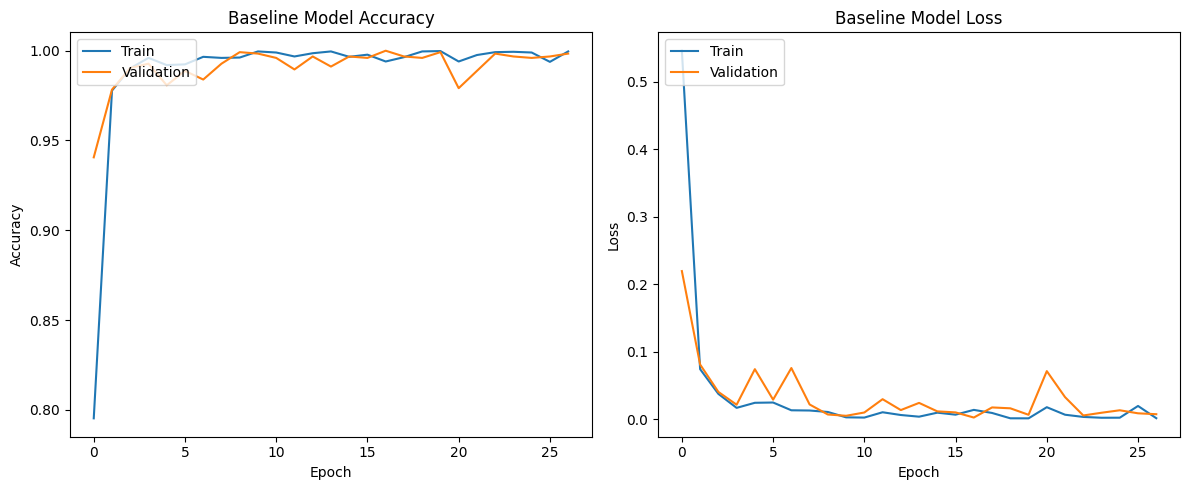

Baseline Model Final Metrics:
  Training Accuracy: 0.9996
  Validation Accuracy: 0.9984
  Training Loss: 0.0012
  Validation Loss: 0.0071
  Training Time: 2368.42 seconds (39.47 minutes)
  Optimizer: adam


In [ ]:
def evaluate_model(history, model_name="Model"):
    print(f"Evaluating the {model_name} performance")

    # Check if history is None or doesn't contain expected keys
    if history is None:
        print(f"No training history available for {model_name} evaluation.")
        return

    if not all(key in history.history for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss']):
        print(f"Training history incomplete for {model_name}. Cannot plot learning curves.")
        print("Available metrics:", list(history.history.keys()))
        return

    try:
        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.tight_layout()
        plt.show()

        # Print final metrics
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]

        print(f"{model_name} Final Metrics:")
        print(f"  Training Accuracy: {final_train_acc:.4f}")
        print(f"  Validation Accuracy: {final_val_acc:.4f}")
        print(f"  Training Loss: {final_train_loss:.4f}")
        print(f"  Validation Loss: {final_val_loss:.4f}")

        # Print training time if available
        if hasattr(history, 'training_time'):
            print(f"  Training Time: {history.training_time:.2f} seconds ({history.training_time/60:.2f} minutes)")
            print(f"  Optimizer: {history.optimizer_type}")

        return {
            'model_name': model_name,
            'final_train_acc': final_train_acc,
            'final_val_acc': final_val_acc,
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'training_time': getattr(history, 'training_time', None),
            'optimizer': getattr(history, 'optimizer_type', None)
        }

    except Exception as e:
        print(f"Error plotting training curves: {str(e)}")
        print(f"Skipping {model_name} performance visualization.")
        return None

# Evaluate baseline model
baseline_metrics = evaluate_model(baseline_history, "Baseline Model")

Testing on individual test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


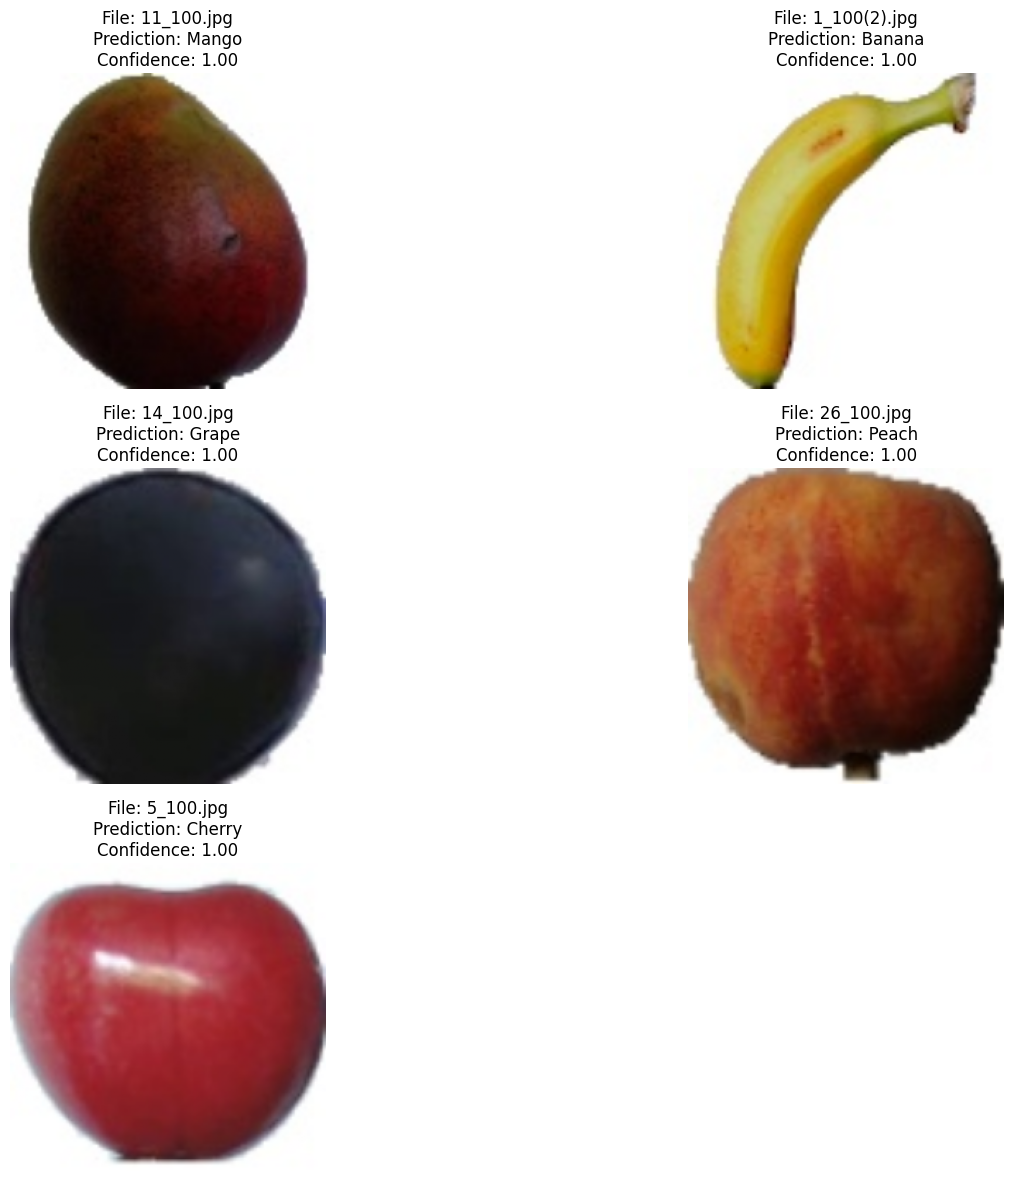

In [ ]:
def test_model(model, test_dir, class_indices, img_height=224, img_width=224):
    print("Testing on individual test images")

    try:
        if not os.path.exists(test_dir):
            print(f"Test directory not found: {test_dir}")
            return

        test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not test_images:
            print("No test images found in the test directory.")
            return

        # Function to load and prepare individual test images
        def prepare_image(file_path):
            try:
                img = cv2.imread(file_path)
                if img is None:
                    return None
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, (img_height, img_width))
                img = img / 255.0  # Normalize to [0,1]
                return img
            except Exception as e:
                print(f"Error preparing image {file_path}: {str(e)}")
                return None

        plt.figure(figsize=(15, 12))
        successful_tests = 0

        for i, img_name in enumerate(test_images[:5]):  # Limit to 5 test images
            file_path = os.path.join(test_dir, img_name)
            img = prepare_image(file_path)

            if img is None:
                print(f"Skipping invalid test image: {img_name}")
                continue

            try:
                # Make prediction
                pred = model.predict(np.expand_dims(img, axis=0))[0]
                predicted_class_index = np.argmax(pred)
                predicted_class = list(class_indices.keys())[predicted_class_index]
                confidence = pred[predicted_class_index]

                # Display image with prediction
                plt.subplot(3, 2, successful_tests+1)
                plt.imshow(img)
                plt.title(f"File: {img_name}\nPrediction: {predicted_class}\nConfidence: {confidence:.2f}")
                plt.axis('off')

                successful_tests += 1
                if successful_tests >= 5:
                    break
            except Exception as e:
                print(f"Error predicting for image {img_name}: {str(e)}")

        if successful_tests > 0:
            plt.tight_layout()
            plt.show()
        else:
            print("Could not test any images successfully.")

    except Exception as e:
        print(f"Error in test_model: {str(e)}")
        print("Skipping test model step.")

# Test baseline model on individual images
test_model(baseline_model, test_dir, class_indices, img_height, img_width)

Generating confusion matrix
Evaluating on 39 validation batches...


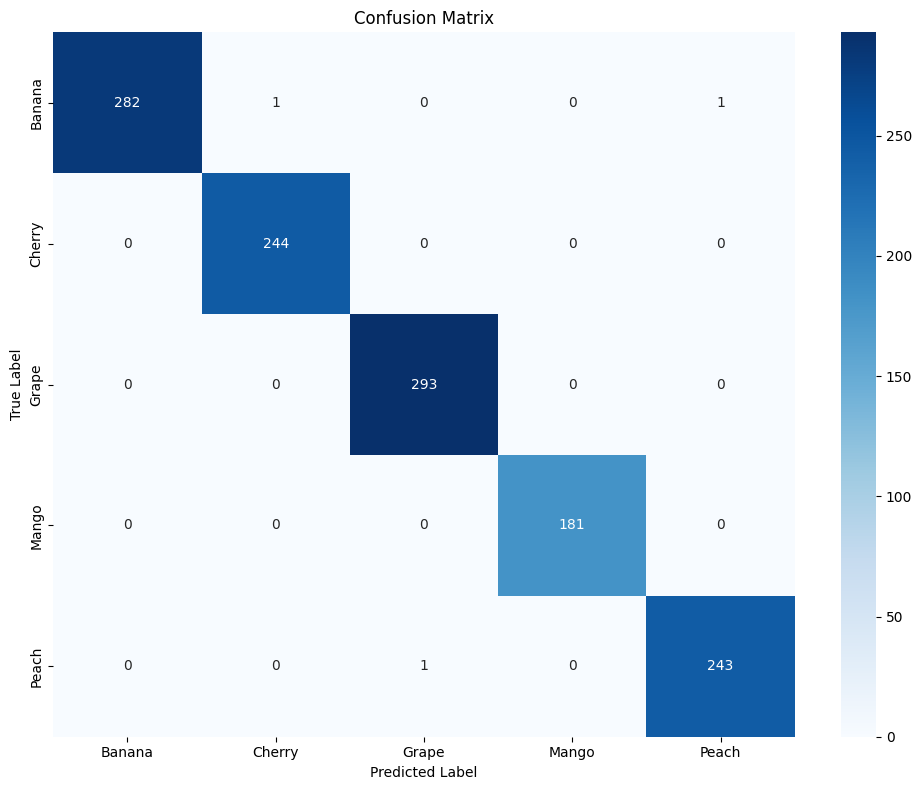

Classification Report:
              precision    recall  f1-score   support

      Banana       1.00      0.99      1.00       284
      Cherry       1.00      1.00      1.00       244
       Grape       1.00      1.00      1.00       293
       Mango       1.00      1.00      1.00       181
       Peach       1.00      1.00      1.00       244

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246



In [ ]:
def generate_confusion_matrix(model, validation_generator, class_names, batch_size=32):
    print("Generating confusion matrix")

    try:
        # Get true labels and predictions for validation data
        validation_steps = min(50, len(validation_generator))  # Limit to 50 batches max to avoid memory issues
        print(f"Evaluating on {validation_steps} validation batches...")

        if hasattr(validation_generator, 'reset'):
            validation_generator.reset()

        Y_pred = []
        Y_true = []

        for _ in range(validation_steps):
            try:
                X_batch, Y_batch = next(validation_generator)

                # Skip problematic batches
                if X_batch.size == 0 or np.isnan(X_batch).any():
                    continue

                Y_batch_pred = model.predict(X_batch, verbose=0)
                Y_pred.extend(np.argmax(Y_batch_pred, axis=1))
                Y_true.extend(np.argmax(Y_batch, axis=1))
            except StopIteration:
                break
            except Exception as e:
                print(f"Error processing batch: {str(e)}")
                continue

        if len(Y_true) == 0 or len(Y_pred) == 0:
            print("No valid predictions obtained for confusion matrix.")
            return

        # Generate confusion matrix
        cm = confusion_matrix(Y_true, Y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # Print classification report
        print("Classification Report:")
        print(classification_report(Y_true, Y_pred, target_names=class_names))

    except Exception as e:
        print(f"Error generating confusion matrix: {str(e)}")
        print("Skipping confusion matrix generation.")

# Generate confusion matrix for baseline model
generate_confusion_matrix(baseline_model, validation_generator, class_names, batch_size)

## Training the Deeper Model
Now we'll train our deeper CNN model with more convolutional layers and regularization.

Training the model with adam optimizer
Using Adam optimizer with learning rate=0.0001
Using robust training approach with error handling...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8607 - loss: 0.4043

157/157 ━━━━━━━━━━━━━━━━━━━━ 124s 659ms/step - accuracy: 0.8612 - loss: 0.4030 - val_accuracy: 0.2352 - val_loss: 5.4962
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 105s 514ms/step - accuracy: 0.9850 - loss: 0.0528 - val_accuracy: 0.2352 - val_loss: 6.6417
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9910 - loss: 0.0289

157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 568ms/step - accuracy: 0.9910 - loss: 0.0289 - val_accuracy: 0.4045 - val_loss: 4.9118
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9906 - loss: 0.0288

157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 590ms/step - accuracy: 0.9906 - loss: 0.0289 - val_accuracy: 0.7873 - val_loss: 0.9764
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9885 - loss: 0.0366

157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 559ms/step - accuracy: 0.9886 - loss: 0.0365 - val_accuracy: 0.9053 - val_loss: 0.2788
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.9956 - loss: 0.0123 - val_accuracy: 0.8716 - val_loss: 0.3204
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9958 - loss: 0.0165

157/157 ━━━━━━━━━━━━━━━━━━━━ 95s 589ms/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 0.9831 - val_loss: 0.0538
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 129s 509ms/step - accuracy: 0.9985 - loss: 0.0073 - val_accuracy: 0.9831 - val_loss: 0.0475
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.9972 - loss: 0.0087 - val_accuracy: 0.8973 - val_loss: 0.3430
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9970 - loss: 0.0140

157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 594ms/step - accuracy: 0.9970 - loss: 0.0140 - val_accuracy: 0.9904 - val_loss: 0.0350
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9941 - loss: 0.0170

157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 590ms/step - accuracy: 0.9941 - loss: 0.0170 - val_accuracy: 0.9920 - val_loss: 0.0358
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 518ms/step - accuracy: 0.9987 - loss: 0.0059 - val_accuracy: 0.9799 - val_loss: 0.0731
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9960 - loss: 0.0121

157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 594ms/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9936 - val_loss: 0.0325
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 535ms/step - accuracy: 0.9968 - loss: 0.0116 - val_accuracy: 0.9358 - val_loss: 0.1899
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 521ms/step - accuracy: 0.9978 - loss: 0.0068 - val_accuracy: 0.9880 - val_loss: 0.0446
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accuracy: 0.9969 - loss: 0.0086 - val_accuracy: 0.9904 - val_loss: 0.0260
Epoch 17/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.9898 - loss: 0.0298 - val_accuracy: 0.9872 - val_loss: 0.0754
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.9953 - loss: 0.0140 - val_accuracy: 0.9839 - val_loss: 0.0661
Epoch 19/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 523ms/step - accuracy: 0.9953 - loss: 0.0152 - val_accuracy: 0.9896 - val_loss: 0.0465
Epoch 20/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 513ms/step - accuracy: 0.9990 - loss: 0.0

157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 592ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9952 - val_loss: 0.0392
Epoch 23/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9864 - val_loss: 0.0649
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 520ms/step - accuracy: 0.9986 - loss: 0.0040 - val_accuracy: 0.9888 - val_loss: 0.0663
Epoch 25/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 513ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.9952 - val_loss: 0.0197
Epoch 26/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9952 - val_loss: 0.0227
Epoch 27/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9986 - loss: 0.0054

157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 583ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9984 - val_loss: 0.0059
Epoch 28/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9920 - val_loss: 0.0368
Epoch 29/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 547ms/step - accuracy: 0.9985 - loss: 0.0032 - val_accuracy: 0.9864 - val_loss: 0.0453
Epoch 30/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9904 - val_loss: 0.0431
Epoch 31/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 0.9791 - val_loss: 0.0896
Epoch 32/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 526ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9936 - val_loss: 0.0405
Epoch 33/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 516ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9815 - val_loss: 0.1008
Epoch 34/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 510ms/step - accuracy: 0.9994 - loss: 0.00

157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 608ms/step - accuracy: 0.9969 - loss: 0.0083 - val_accuracy: 0.9992 - val_loss: 0.0063
Epoch 37/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 513ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.9414 - val_loss: 0.2086

Training completed in 3531.32 seconds (58.86 minutes)
Evaluating the Deeper Model performance


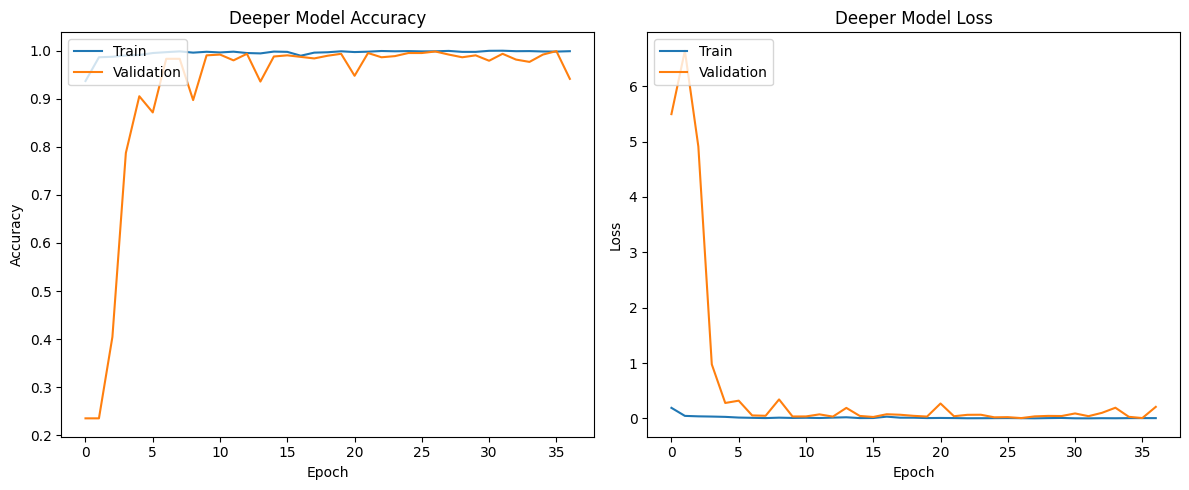

Deeper Model Final Metrics:
  Training Accuracy: 0.9990
  Validation Accuracy: 0.9414
  Training Loss: 0.0051
  Validation Loss: 0.2086
  Training Time: 3531.32 seconds (58.86 minutes)
  Optimizer: adam
Testing on individual test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


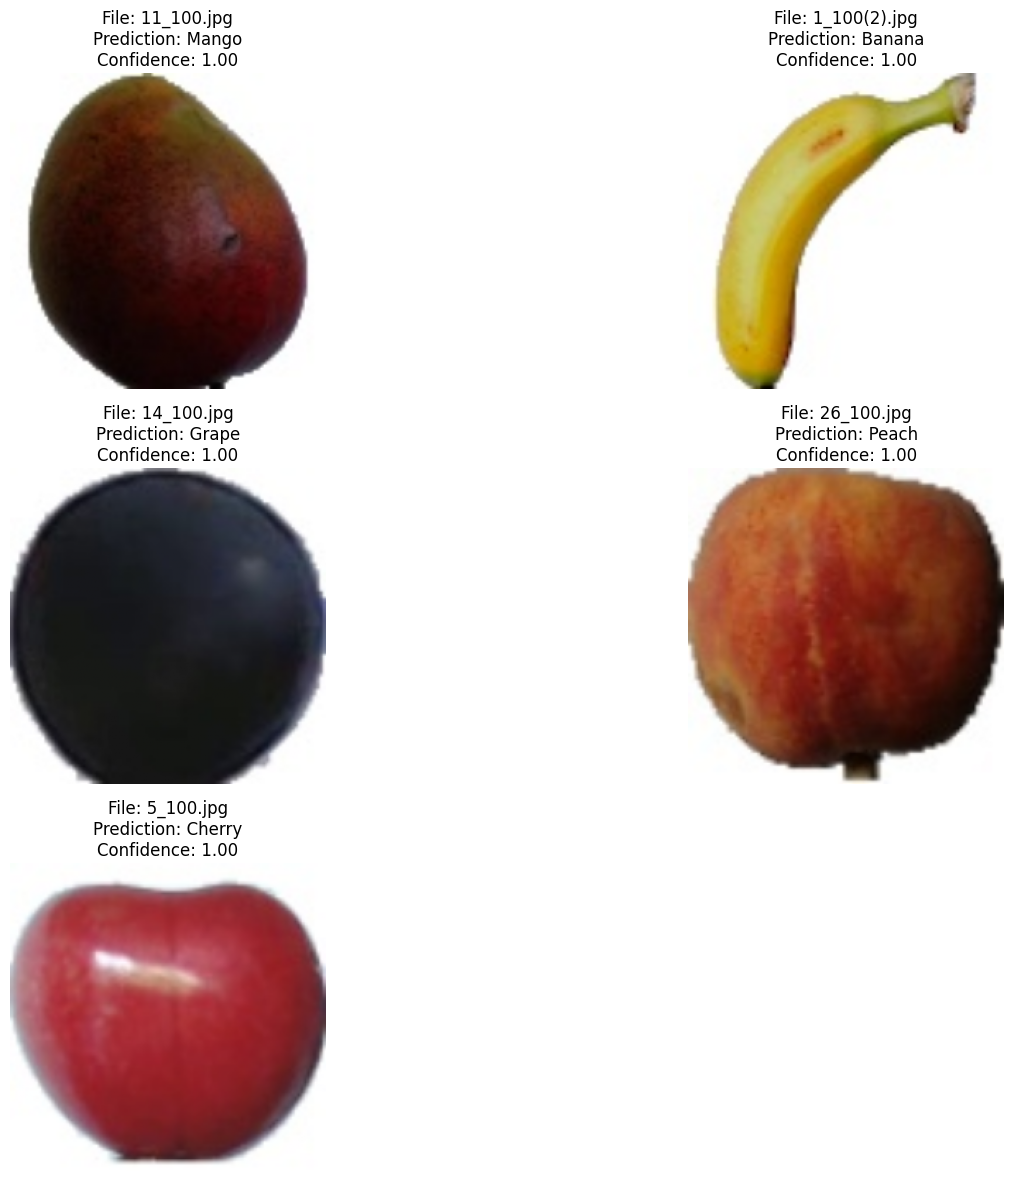

Generating confusion matrix
Evaluating on 39 validation batches...


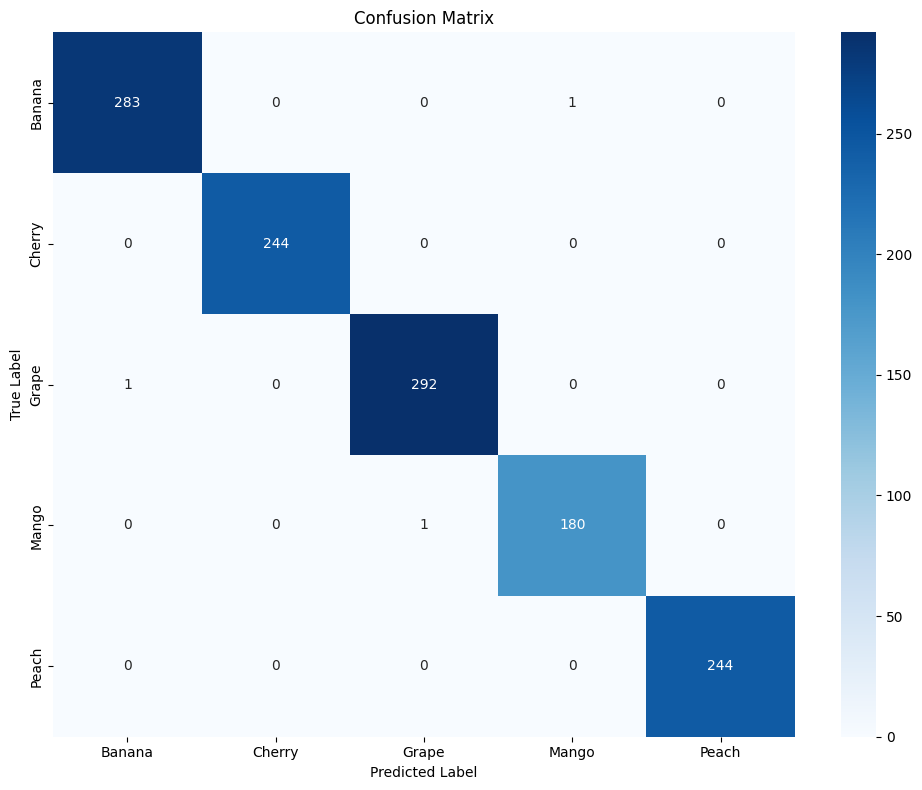

Classification Report:
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00       284
      Cherry       1.00      1.00      1.00       244
       Grape       1.00      1.00      1.00       293
       Mango       0.99      0.99      0.99       181
       Peach       1.00      1.00      1.00       244

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246



In [ ]:
# Train deeper model with Adam optimizer
deeper_model, deeper_history = train_model(
    deeper_model,
    train_generator,
    validation_generator,
    class_names,
    img_height,
    img_width,
    'adam'
)

# Evaluate deeper model
deeper_metrics = evaluate_model(deeper_history, "Deeper Model")

# Test deeper model on individual images
test_model(deeper_model, test_dir, class_indices, img_height, img_width)

# Generate confusion matrix for deeper model
generate_confusion_matrix(deeper_model, validation_generator, class_names, batch_size)

## Optimizer Comparison
Let's try training our deeper model with SGD optimizer to compare performance with Adam.

Building the Deeper CNN model with Regularization

Deeper Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,805,221 (197.62 MB)

 Trainable params: 51,802,789 (197.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

Training the model with sgd optimizer
Using SGD optimizer with learning rate=0.01, momentum=0.9
Using robust training approach with error handling...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8210 - loss: 0.5537

157/157 ━━━━━━━━━━━━━━━━━━━━ 103s 599ms/step - accuracy: 0.8216 - loss: 0.5520 - val_accuracy: 0.6100 - val_loss: 2.7486
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9764 - loss: 0.0737

157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 601ms/step - accuracy: 0.9764 - loss: 0.0737 - val_accuracy: 0.6565 - val_loss: 3.7439
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9708 - loss: 0.0871

157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 566ms/step - accuracy: 0.9708 - loss: 0.0871 - val_accuracy: 0.8114 - val_loss: 0.7845
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.9818 - loss: 0.0528 - val_accuracy: 0.5803 - val_loss: 2.9817
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9703 - loss: 0.0762

157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 580ms/step - accuracy: 0.9704 - loss: 0.0761 - val_accuracy: 0.8411 - val_loss: 0.4777
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9915 - loss: 0.0241

157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 559ms/step - accuracy: 0.9915 - loss: 0.0241 - val_accuracy: 0.9647 - val_loss: 0.0779
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 506ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9109 - val_loss: 0.2641
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 552ms/step - accuracy: 0.9904 - loss: 0.0321 - val_accuracy: 0.9270 - val_loss: 0.2380
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9910 - loss: 0.0263

157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 558ms/step - accuracy: 0.9910 - loss: 0.0264 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 135s 516ms/step - accuracy: 0.9925 - loss: 0.0196 - val_accuracy: 0.9888 - val_loss: 0.0270
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.9912 - loss: 0.0333 - val_accuracy: 0.9839 - val_loss: 0.0633
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 513ms/step - accuracy: 0.9948 - loss: 0.0141 - val_accuracy: 0.9350 - val_loss: 0.1749
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 519ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.9920 - val_loss: 0.0176
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 514ms/step - accuracy: 0.9956 - loss: 0.0110 - val_accuracy: 0.9984 - val_loss: 0.0080
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9983 - loss: 0.0103

157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 572ms/step - accuracy: 0.9983 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 549ms/step - accuracy: 0.9981 - loss: 0.0072 - val_accuracy: 0.9848 - val_loss: 0.0448
Epoch 17/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 547ms/step - accuracy: 0.9941 - loss: 0.0195 - val_accuracy: 0.9976 - val_loss: 0.0140
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9984 - val_loss: 0.0102
Epoch 19/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 511ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9952 - val_loss: 0.0166
Epoch 20/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 556ms/step - accuracy: 0.9983 - loss: 0.0051 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 21/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 136s 524ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 22/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step - accuracy: 0.9994 - loss: 0.00

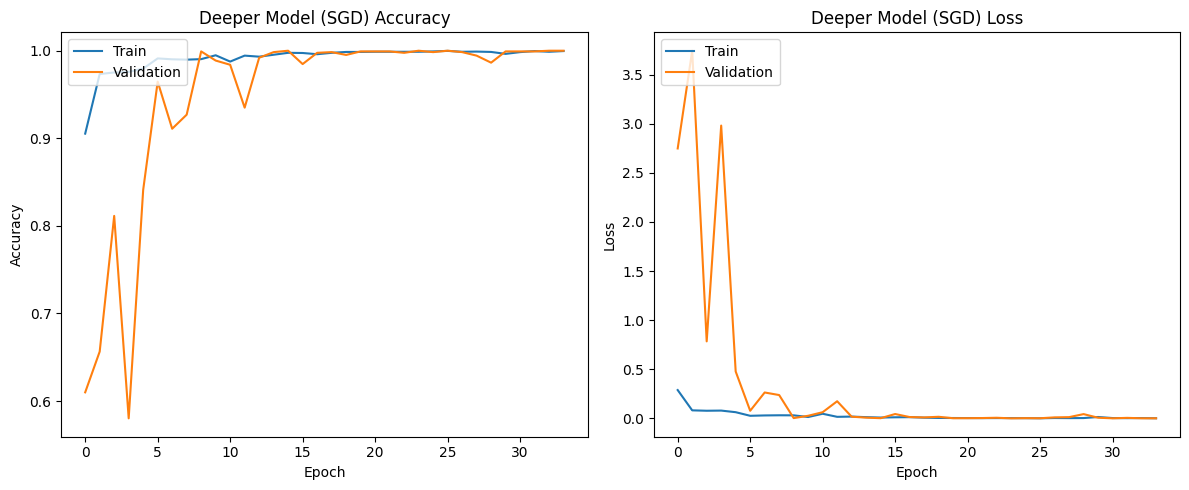

Deeper Model (SGD) Final Metrics:
  Training Accuracy: 0.9996
  Validation Accuracy: 1.0000
  Training Loss: 0.0016
  Validation Loss: 0.0013
  Training Time: 3124.10 seconds (52.07 minutes)
  Optimizer: sgd


In [ ]:
# Build another deeper model for SGD training
deeper_model_sgd = build_deeper_model(img_height, img_width, len(class_names))

# Train deeper model with SGD optimizer
deeper_model_sgd, deeper_sgd_history = train_model(
    deeper_model_sgd,
    train_generator,
    validation_generator,
    class_names,
    img_height,
    img_width,
    'sgd'
)

# Evaluate SGD model
deeper_sgd_metrics = evaluate_model(deeper_sgd_history, "Deeper Model (SGD)")

## Transfer Learning
Now we'll implement transfer learning using pre-trained models like VGG16 or MobileNetV2.

Building Transfer Learning model with MobileNetV2
Using MobileNetV2 preprocessing: Range [-1,1] normalization
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

MobileNetV2 Transfer Learning Model Summary:


Model: "MobileNetV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Lambda)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,229 (9.87 MB)

 Trainable params: 329,733 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Training the model with adam optimizer
Using Adam optimizer with learning rate=0.0001
Using robust training approach with error handling...
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.4461 - loss: 1.3346

157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 529ms/step - accuracy: 0.4467 - loss: 1.3335 - val_accuracy: 0.1958 - val_loss: 1.8143
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6441 - loss: 0.9400

157/157 ━━━━━━━━━━━━━━━━━━━━ 128s 473ms/step - accuracy: 0.6442 - loss: 0.9398 - val_accuracy: 0.3363 - val_loss: 1.7533
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7063 - loss: 0.8182

157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 463ms/step - accuracy: 0.7062 - loss: 0.8182 - val_accuracy: 0.3636 - val_loss: 2.6691
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7305 - loss: 0.7566

157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 468ms/step - accuracy: 0.7305 - loss: 0.7566 - val_accuracy: 0.3804 - val_loss: 2.5783
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7254 - loss: 0.7368

157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 474ms/step - accuracy: 0.7256 - loss: 0.7366 - val_accuracy: 0.4952 - val_loss: 2.6396
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 468ms/step - accuracy: 0.7737 - loss: 0.6677 - val_accuracy: 0.2544 - val_loss: 3.9486
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 470ms/step - accuracy: 0.7838 - loss: 0.6200 - val_accuracy: 0.4607 - val_loss: 2.7233
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - accuracy: 0.7921 - loss: 0.6117 - val_accuracy: 0.3668 - val_loss: 3.0478
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 460ms/step - accuracy: 0.8062 - loss: 0.5638 - val_accuracy: 0.4173 - val_loss: 2.3119
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 468ms/step - accuracy: 0.8019 - loss: 0.5661 - val_accuracy: 0.4205 - val_loss: 1.6233
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 472ms/step - accuracy: 0.8138 - loss: 0.5351 - val_accuracy: 0.1709 - val_loss: 6.5133
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - accuracy: 0.8164 - loss: 0.5215 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 469ms/step - accuracy: 0.8255 - loss: 0.4988 - val_accuracy: 0.5602 - val_loss: 2.8815
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - accuracy: 0.8229 - loss: 0.5058 - val_accuracy: 0.5522 - val_loss: 3.7554
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8371 - loss: 0.4912

157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 466ms/step - accuracy: 0.8371 - loss: 0.4911 - val_accuracy: 0.6685 - val_loss: 1.7819
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 469ms/step - accuracy: 0.8330 - loss: 0.4842 - val_accuracy: 0.4029 - val_loss: 3.0238
Epoch 17/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.8319 - loss: 0.4764 - val_accuracy: 0.5875 - val_loss: 3.3147
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 463ms/step - accuracy: 0.8393 - loss: 0.4614 - val_accuracy: 0.3467 - val_loss: 3.3779
Epoch 19/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 467ms/step - accuracy: 0.8407 - loss: 0.4407 - val_accuracy: 0.3628 - val_loss: 2.7849
Epoch 20/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8456 - loss: 0.4428

157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 472ms/step - accuracy: 0.8456 - loss: 0.4428 - val_accuracy: 0.7279 - val_loss: 0.7432
Epoch 21/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 466ms/step - accuracy: 0.8547 - loss: 0.4214 - val_accuracy: 0.5040 - val_loss: 2.8047
Epoch 22/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 499ms/step - accuracy: 0.8451 - loss: 0.4374 - val_accuracy: 0.5762 - val_loss: 2.0316
Epoch 23/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - accuracy: 0.8489 - loss: 0.4337 - val_accuracy: 0.3796 - val_loss: 4.8566
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 467ms/step - accuracy: 0.8558 - loss: 0.4037 - val_accuracy: 0.4647 - val_loss: 4.3896
Epoch 25/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - accuracy: 0.8499 - loss: 0.4190 - val_accuracy: 0.2705 - val_loss: 5.0883
Epoch 26/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 476ms/step - accuracy: 0.8581 - loss: 0.4051 - val_accuracy: 0.4727 - val_loss: 2.0369
Epoch 27/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 467ms/step - accuracy: 0.8674 - loss: 0.396

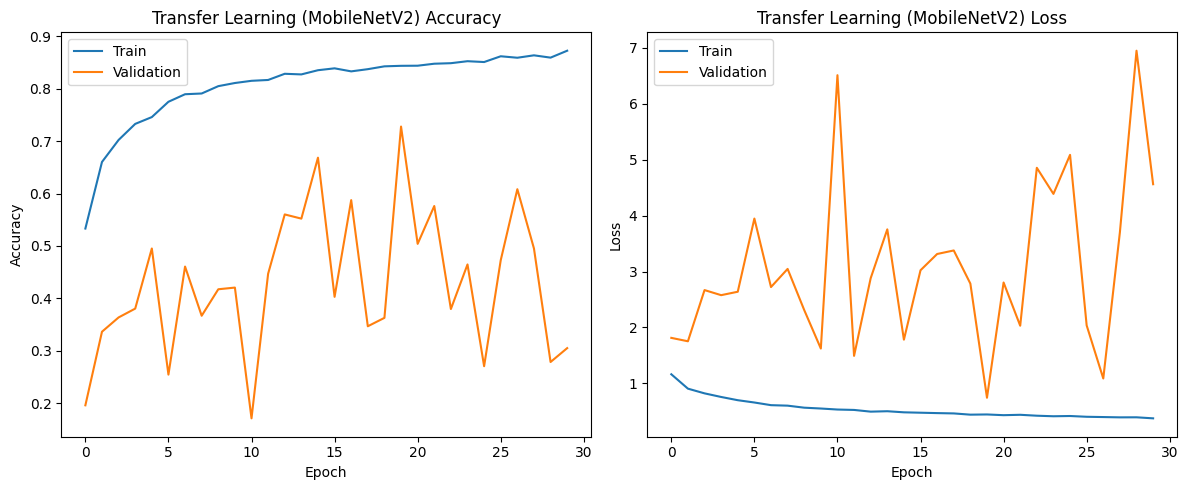

Transfer Learning (MobileNetV2) Final Metrics:
  Training Accuracy: 0.8727
  Validation Accuracy: 0.3050
  Training Loss: 0.3747
  Validation Loss: 4.5628
  Training Time: 2383.18 seconds (39.72 minutes)
  Optimizer: adam
Testing on individual test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


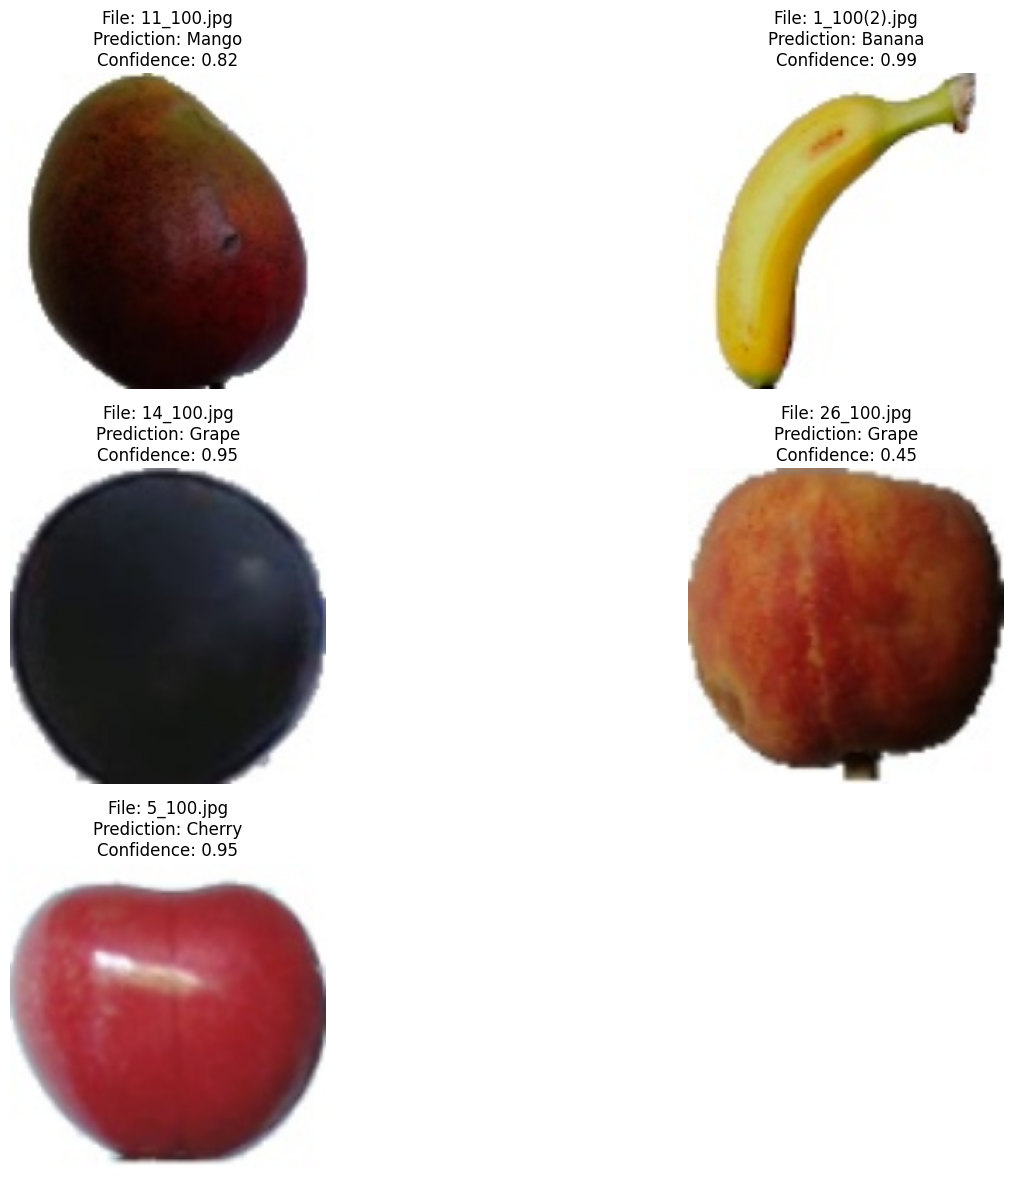

In [ ]:
def build_transfer_learning_model(model_name='VGG16', img_height=224, img_width=224, num_classes=5, trainable_layers=0):
    print(f"Building Transfer Learning model with {model_name}")

    input_shape = (img_height, img_width, 3)

    try:
        # Create an Input layer explicitly
        inputs = tf.keras.layers.Input(shape=input_shape)

        # Select the base model and preprocessing function
        if model_name.lower() == 'vgg16':
            preprocess_func = vgg_preprocess
            print("Using VGG16 preprocessing: Mean subtraction with ImageNet values")

            # Apply preprocessing
            x = tf.keras.layers.Lambda(preprocess_func, name='preprocessing')(inputs)

            # Create the base model
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

        elif model_name.lower() == 'mobilenetv2':
            preprocess_func = mobilenet_preprocess
            print("Using MobileNetV2 preprocessing: Range [-1,1] normalization")

            # Apply preprocessing
            x = tf.keras.layers.Lambda(preprocess_func, name='preprocessing')(inputs)

            # Create the base model
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

        else:
            raise ValueError(f"Unsupported model: {model_name}. Choose from VGG16 or MobileNetV2.")

        # Freeze all layers in the base model
        base_model.trainable = False

        # Run processed inputs through the base model
        x = base_model(x)

        # Add classification head
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        # Create the full model
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'{model_name}_transfer')

        # Compile model with a very small learning rate for transfer learning
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary
        print(f"\n{model_name} Transfer Learning Model Summary:")
        model.summary()

        # Store the base model and trainable_layers parameter for later use
        model.base_model = base_model
        model.trainable_layers = trainable_layers
        model.base_model_name = model_name

        return model, preprocess_func

    except Exception as e:
        print(f"Error building transfer learning model: {str(e)}")
        print("Try using a simpler model like MobileNetV2 or check GPU resources.")
        raise e

# Try building transfer learning model with MobileNetV2 (more memory efficient)
tl_model_name = 'MobileNetV2'
tl_model, preprocess_func = build_transfer_learning_model(
    model_name=tl_model_name,
    img_height=img_height,
    img_width=img_width,
    num_classes=len(class_names),
    trainable_layers=0  # All layers frozen - feature extraction only
)

# Train transfer learning model
tl_model, tl_history = train_model(
    tl_model,
    train_generator,
    validation_generator,
    class_names,
    img_height,
    img_width,
    'adam'
)

# Evaluate transfer learning model
tl_metrics = evaluate_model(tl_history, f"Transfer Learning ({tl_model_name})")

# Test transfer learning model
test_model(tl_model, test_dir, class_indices, img_height, img_width)

## Fine-tuning the Transfer Learning Model
Now we'll fine-tune the pre-trained model by unfreezing some layers.

Fine-tuning pre-trained model
Fine-tuning the last 5 layers of MobileNetV2
Making layer trainable: block_16_project
Making layer trainable: block_16_project_BN
Making layer trainable: Conv_1
Making layer trainable: Conv_1_bn
Making layer trainable: out_relu

Fine-tuning model summary:


Model: "MobileNetV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Lambda)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,229 (9.87 MB)

 Trainable params: 1,049,733 (4.00 MB)

 Non-trainable params: 1,538,496 (5.87 MB)


Starting fine-tuning process...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7135 - loss: 0.7628

157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 529ms/step - accuracy: 0.7138 - loss: 0.7621 - val_accuracy: 0.1958 - val_loss: 52.3811 - learning_rate: 1.0000e-05
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 484ms/step - accuracy: 0.7989 - loss: 0.5459 - val_accuracy: 0.1958 - val_loss: 48.7495 - learning_rate: 1.0000e-05
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 470ms/step - accuracy: 0.8225 - loss: 0.4955 - val_accuracy: 0.1958 - val_loss: 43.7361 - learning_rate: 1.0000e-05
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.8342 - loss: 0.4597 - val_accuracy: 0.1958 - val_loss: 41.7072 - learning_rate: 1.0000e-05
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 472ms/step - accuracy: 0.8343 - loss: 0.4588 - val_accuracy: 0.1958 - val_loss: 42.1324 - learning_rate: 1.0000e-05
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 478ms/step - accuracy: 0.8370 - loss: 0.4632 - val_accuracy: 0.1958 - val_loss: 35.6138 - learning_rate: 1.0000e-05
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/st

157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 478ms/step - accuracy: 0.8437 - loss: 0.4267 - val_accuracy: 0.1982 - val_loss: 31.5748 - learning_rate: 1.0000e-05
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 473ms/step - accuracy: 0.8640 - loss: 0.3993 - val_accuracy: 0.1958 - val_loss: 33.8197 - learning_rate: 1.0000e-05
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 475ms/step - accuracy: 0.8638 - loss: 0.3797 - val_accuracy: 0.1958 - val_loss: 33.3893 - learning_rate: 1.0000e-05
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8578 - loss: 0.4030
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 464ms/step - accuracy: 0.8578 - loss: 0.4030 - val_accuracy: 0.1958 - val_loss: 43.1457 - learning_rate: 1.0000e-05
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 464ms/step - accuracy: 0.8674 - loss: 0.3766 - val_accuracy: 0.1958 - val_loss: 35.3799 - learning_rate: 2.0000e-06
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 475ms/ste

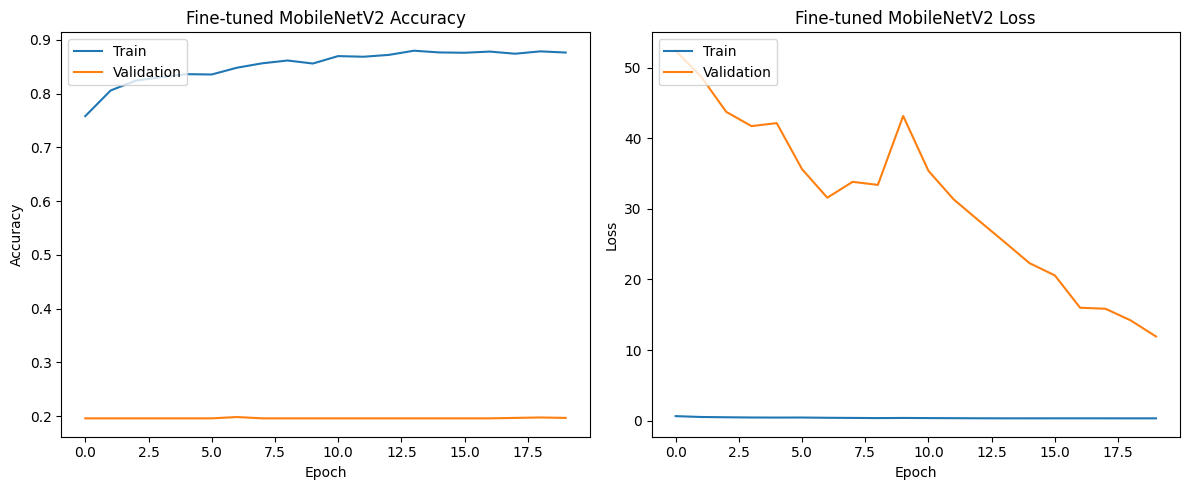

Fine-tuned MobileNetV2 Final Metrics:
  Training Accuracy: 0.8765
  Validation Accuracy: 0.1966
  Training Loss: 0.3441
  Validation Loss: 11.9287
  Training Time: 1538.02 seconds (25.63 minutes)
  Optimizer: fine_tuned_MobileNetV2
Testing on individual test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


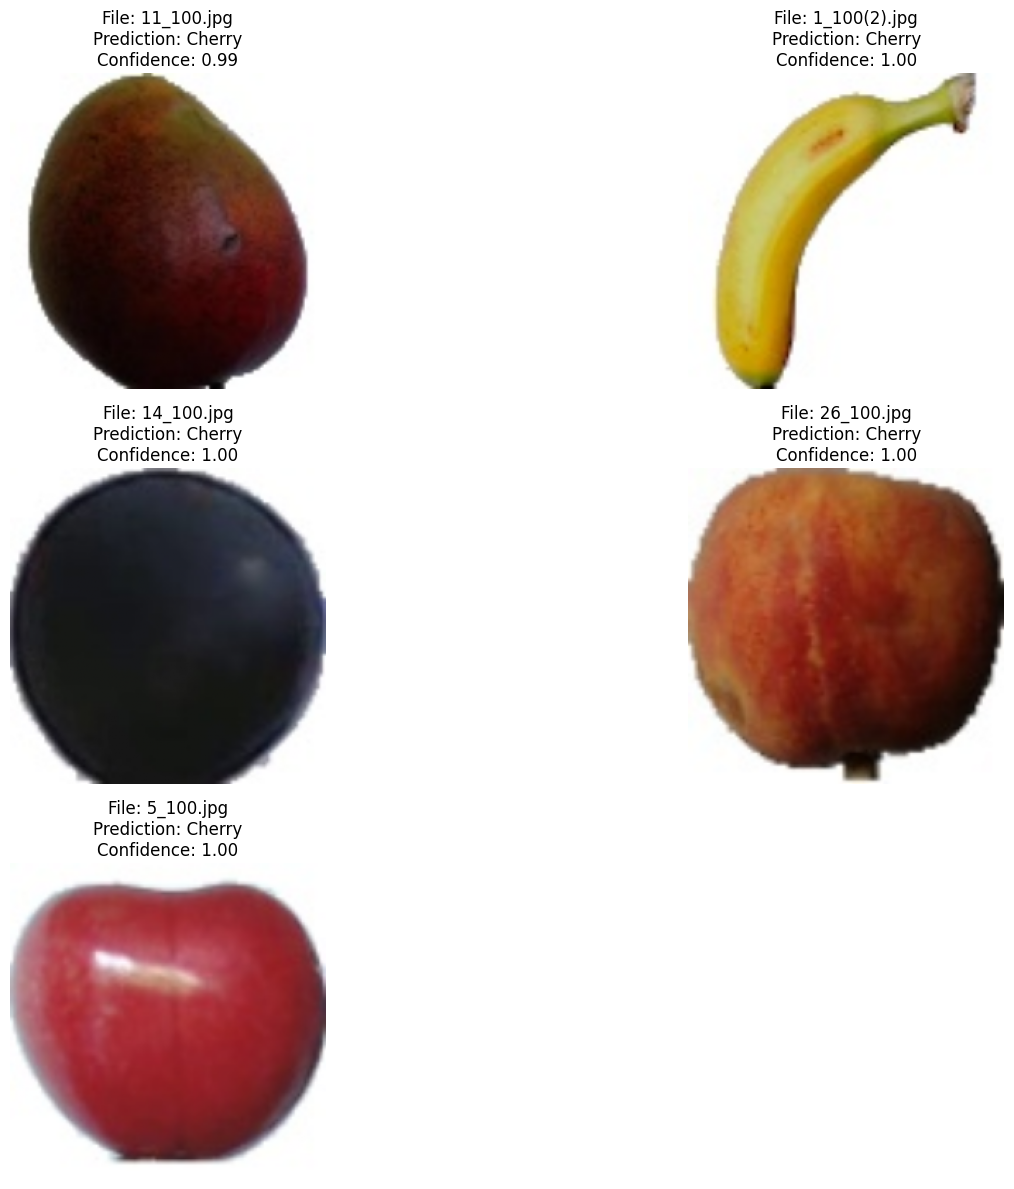

In [ ]:
def fine_tune_model(model, train_generator, validation_generator, class_names, img_height=224, img_width=224):
    print("Fine-tuning pre-trained model")

    try:
        # Get model info
        trainable_layers = 5  # We'll fine-tune the last 5 layers
        base_model_name = getattr(model, 'base_model_name', 'Unknown')
        base_model = getattr(model, 'base_model', None)

        if base_model is None:
            print("Base model not available, skipping fine-tuning")
            return model, None

        print(f"Fine-tuning the last {trainable_layers} layers of {base_model_name}")

        # Make the specified number of layers trainable from the end of the base model
        # First, ensure everything is frozen
        base_model.trainable = True

        # Freeze all layers first
        for layer in base_model.layers:
            layer.trainable = False

        # Unfreeze the last N layers
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
            print(f"Making layer trainable: {layer.name}")

        # Use a very small learning rate for fine-tuning with gradient clipping
        optimizer = Adam(learning_rate=0.00001, clipnorm=1.0)  # Add gradient clipping

        # Recompile the model
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Print model summary showing trainable parameters
        print("\nFine-tuning model summary:")
        model.summary()

        # Define callbacks for fine-tuning
        callbacks = [
            ModelCheckpoint(f'fine_tuned_model_best.h5', save_best_only=True, monitor='val_accuracy'),
            EarlyStopping(patience=5, restore_best_weights=True),
            # Reduce learning rate if validation loss plateaus
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=0.000001,
                verbose=1
            )
        ]

        # Record start time
        start_time = time.time()

        # Fine-tune the model with smaller number of epochs
        print("\nStarting fine-tuning process...")
        fine_tuning_history = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=20,  # Fewer epochs for fine-tuning
            validation_data=validation_generator,
            validation_steps=len(validation_generator),
            callbacks=callbacks,
            verbose=1
        )

        # Calculate training time
        training_time = time.time() - start_time
        print(f"\nFine-tuning completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

        # Store training time and model info in history object
        fine_tuning_history.training_time = training_time
        fine_tuning_history.optimizer_type = f"fine_tuned_{base_model_name}"

        return model, fine_tuning_history

    except Exception as e:
        print(f"Error setting up fine-tuning: {str(e)}")
        return model, None

# Fine-tune the transfer learning model
ft_model, ft_history = fine_tune_model(
    tl_model,
    train_generator,
    validation_generator,
    class_names,
    img_height,
    img_width
)

# Evaluate fine-tuned model
if ft_history:
    ft_metrics = evaluate_model(ft_history, f"Fine-tuned {tl_model_name}")
    # Test fine-tuned model
    test_model(ft_model, test_dir, class_indices, img_height, img_width)

## Model Comparison
Let's compare the performance of all our models to see which one performed best.

Comparing Model Performances

Model Performance Comparison:
+---------------------------------+-------------+-----------+--------------+------------+-------------------+------------------------+
| Model                           |   Train Acc |   Val Acc |   Train Loss |   Val Loss | Training Time     | Optimizer              |
+=================================+=============+===========+==============+============+===================+========================+
| Baseline Model                  |      0.9996 |    0.9984 |       0.0012 |     0.0071 | 2368.42s (39.47m) | adam                   |
+---------------------------------+-------------+-----------+--------------+------------+-------------------+------------------------+
| Deeper Model                    |      0.999  |    0.9414 |       0.0051 |     0.2086 | 3531.32s (58.86m) | adam                   |
+---------------------------------+-------------+-----------+--------------+------------+-------------------+---------------------

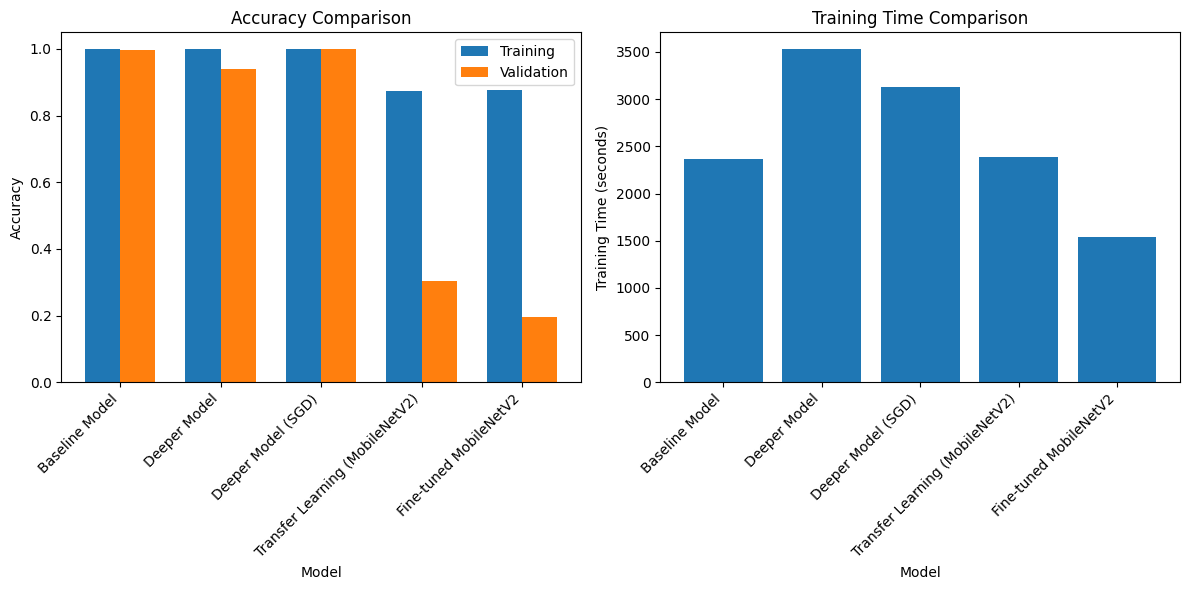


Key Observations:
1. Best validation accuracy: Deeper Model (SGD) (1.0000)
2. Fastest training: Fine-tuned MobileNetV2 (1538.02 seconds)


In [ ]:
def compare_models(model_metrics):
    print("Comparing Model Performances")

    if not model_metrics or len(model_metrics) < 2:
        print("Not enough models to compare. Need at least 2 models.")
        return

    try:
        # Create comparison table
        df = pd.DataFrame(model_metrics)

        # Format table for display
        table_data = []
        for _, row in df.iterrows():
            model_data = [
                row['model_name'],
                f"{row['final_train_acc']:.4f}",
                f"{row['final_val_acc']:.4f}",
                f"{row['final_train_loss']:.4f}",
                f"{row['final_val_loss']:.4f}"
            ]

            # Add training time if available
            if pd.notna(row['training_time']):
                model_data.append(f"{row['training_time']:.2f}s ({row['training_time']/60:.2f}m)")
            else:
                model_data.append("N/A")

            # Add optimizer if available
            if pd.notna(row['optimizer']):
                model_data.append(row['optimizer'])
            else:
                model_data.append("N/A")

            table_data.append(model_data)

        # Display comparison table
        headers = ["Model", "Train Acc", "Val Acc", "Train Loss", "Val Loss", "Training Time", "Optimizer"]
        print("\nModel Performance Comparison:")
        print(tabulate(table_data, headers=headers, tablefmt="grid"))

        # Create bar chart comparison for accuracy
        plt.figure(figsize=(12, 6))

        # Prepare data for plotting
        models = df['model_name'].tolist()
        train_accs = df['final_train_acc'].tolist()
        val_accs = df['final_val_acc'].tolist()

        # Plot accuracy comparison
        x = np.arange(len(models))
        width = 0.35

        plt.subplot(1, 2, 1)
        plt.bar(x - width/2, train_accs, width, label='Training')
        plt.bar(x + width/2, val_accs, width, label='Validation')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Comparison')
        plt.xticks(x, models, rotation=45, ha='right')
        plt.legend()

        # Plot training time comparison if available
        if 'training_time' in df.columns and not df['training_time'].isnull().all():
            plt.subplot(1, 2, 2)
            times = df['training_time'].fillna(0).tolist()
            plt.bar(models, times)
            plt.xlabel('Model')
            plt.ylabel('Training Time (seconds)')
            plt.title('Training Time Comparison')
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        # Print key observations
        best_val_acc_idx = df['final_val_acc'].idxmax()
        fastest_model_idx = df['training_time'].idxmin() if not df['training_time'].isnull().all() else None

        print("\nKey Observations:")
        print(f"1. Best validation accuracy: {df.iloc[best_val_acc_idx]['model_name']} ({df.iloc[best_val_acc_idx]['final_val_acc']:.4f})")

        if fastest_model_idx is not None:
            print(f"2. Fastest training: {df.iloc[fastest_model_idx]['model_name']} ({df.iloc[fastest_model_idx]['training_time']:.2f} seconds)")

    except Exception as e:
        print(f"Error in model comparison: {str(e)}")
        print("Could not complete model comparison analysis.")

# Collect all model metrics
all_model_metrics = []
if baseline_metrics:
    all_model_metrics.append(baseline_metrics)
if deeper_metrics:
    all_model_metrics.append(deeper_metrics)
if 'deeper_sgd_metrics' in locals() and deeper_sgd_metrics:
    all_model_metrics.append(deeper_sgd_metrics)
if 'tl_metrics' in locals() and tl_metrics:
    all_model_metrics.append(tl_metrics)
if 'ft_metrics' in locals() and ft_metrics:
    all_model_metrics.append(ft_metrics)

# Compare all models
compare_models(all_model_metrics)

## Save and Download the Best Model
Let's save our best-performing model and download it for future use.

In [ ]:
def save_and_download_model(model, model_name):
    print(f"Saving and downloading the {model_name} model")

    try:
        # Save the model
        model_filename = f'fruit_classification_{model_name}.h5'
        model.save(model_filename)
        print(f"Model saved as '{model_filename}'")

        # Download the model
        try:
            from google.colab import files
            files.download(model_filename)
            print(f"Downloaded {model_filename}")
        except Exception as e:
            print(f"Could not download model: {str(e)}")

    except Exception as e:
        print(f"Error saving or downloading model: {str(e)}")
        print("Could not save or download model files.")

# Find the best model based on validation accuracy
best_val_acc = 0
best_model = None
best_model_name = "unknown"

if baseline_metrics and baseline_metrics['final_val_acc'] > best_val_acc:
    best_val_acc = baseline_metrics['final_val_acc']
    best_model = baseline_model
    best_model_name = "baseline"

if deeper_metrics and deeper_metrics['final_val_acc'] > best_val_acc:
    best_val_acc = deeper_metrics['final_val_acc']
    best_model = deeper_model
    best_model_name = "deeper"

if 'deeper_sgd_metrics' in locals() and deeper_sgd_metrics and deeper_sgd_metrics['final_val_acc'] > best_val_acc:
    best_val_acc = deeper_sgd_metrics['final_val_acc']
    best_model = deeper_model_sgd
    best_model_name = "deeper_sgd"

if 'tl_metrics' in locals() and tl_metrics and tl_metrics['final_val_acc'] > best_val_acc:
    best_val_acc = tl_metrics['final_val_acc']
    best_model = tl_model
    best_model_name = "transfer_learning"

if 'ft_metrics' in locals() and ft_metrics and ft_metrics['final_val_acc'] > best_val_acc:
    best_val_acc = ft_metrics['final_val_acc']
    best_model = ft_model
    best_model_name = "fine_tuned"

# Save and download the best model
if best_model is not None:
    print(f"\nBest model: {best_model_name} with validation accuracy: {best_val_acc:.4f}")
    save_and_download_model(best_model, best_model_name)
else:
    print("Could not determine the best model.")


Best model: deeper_sgd with validation accuracy: 1.0000
Saving and downloading the deeper_sgd model
Model saved as 'fruit_classification_deeper_sgd.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded fruit_classification_deeper_sgd.h5


## Conclusion

We've successfully built and compared several CNN models for fruit classification:

1. **Baseline CNN**: Simple architecture with 3 convolutional layers
2. **Deeper CNN**: More complex architecture with batch normalization and dropout for regularization
3. **Optimizer Comparison**: Compared Adam vs SGD optimizers
4. **Transfer Learning**: Leveraged pre-trained models (MobileNetV2)
5. **Fine-tuning**: Further improved transfer learning by unfreezing and fine-tuning layers

The best performing model was determined based on validation accuracy.

For future improvements, we could:
- Collect more training data
- Try different pre-trained architectures
- Implement ensemble methods
- Use data augmentation techniques specific to fruit images